In [82]:
# COMP 5300 Final Project
# Musculoskeletal Abnormality Detection
# Michelle, Jennifer, Amelia, Deva

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [84]:
# Display file directory tree
def print_file_directory(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 3 * level
        subindent = ' ' * 3 * (level + 1)
        print('{}{}/'.format(indent, os.path.basename(root)))
        for f in files:
            print('{}{}'.format(subindent, f))

In [85]:
print_file_directory('MURA-v1.1')

MURA-v1.1/
   train_labeled_studies.csv
   train_image_paths.csv
   valid_image_paths.csv
   valid_labeled_studies.csv
   train/
      XR_FOREARM/
         patient09232/
            study1_positive/
               image2.png
               image1.png
         patient09202/
            study1_positive/
               image2.png
               image1.png
         patient09396/
            study1_negative/
               image2.png
               image1.png
         patient09567/
            study1_negative/
               image2.png
               image1.png
         patient09515/
            study1_negative/
               image2.png
               image1.png
         patient09139/
            study1_positive/
               image2.png
               image1.png
         patient09235/
            study1_positive/
               image2.png
               image1.png
         patient09663/
            study1_negative/
               image2.png
               image3.png
               image1

            study1_positive/
               image2.png
               image3.png
               image1.png
               image4.png
         patient01205/
            study1_positive/
               image2.png
               image3.png
               image1.png
               image4.png
         patient02314/
            study1_negative/
               image2.png
               image3.png
               image1.png
               image4.png
         patient01819/
            study1_negative/
               image2.png
               image3.png
               image1.png
         patient01718/
            study1_negative/
               image2.png
               image3.png
               image1.png
         patient00636/
            study1_positive/
               image2.png
               image3.png
               image1.png
               image4.png
         patient01404/
            study1_positive/
               image2.png
               image3.png
               image1.png
         

            study1_negative/
               image2.png
               image1.png
         patient11378/
            study1_negative/
               image2.png
               image1.png
         patient11352/
            study1_positive/
               image2.png
               image1.png
         patient11612/
            study1_positive/
               image2.png
               image1.png
         patient11639/
            study1_positive/
               image2.png
               image1.png
         patient11615/
            study1_positive/
               image2.png
               image1.png
         patient11693/
            study1_negative/
               image2.png
               image1.png
         patient11200/
            study1_negative/
               image2.png
               image1.png
         patient11674/
            study1_negative/
               image2.png
               image1.png
         patient11248/
            study1_positive/
               image2.png
         

In [86]:
# Remove .DS_Store if needed
# ! find . -name '.DS_Store' -type f -delete

In [87]:
# Images stored and separated in folders by upper extremity study type
os.listdir('MURA-v1.1/train')

['XR_FOREARM',
 'XR_HAND',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_WRIST',
 'XR_HUMERUS',
 'XR_ELBOW']

In [88]:
os.listdir('MURA-v1.1/valid')

['XR_FOREARM',
 'XR_HAND',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_WRIST',
 'XR_HUMERUS',
 'XR_ELBOW']

In [89]:
# Restructure and consolidate data with image paths and labels
# Example path: MURA-v1.1/train/XR_HAND/patient05509/study1_negative/image1.png

def restructure_dataset(path):
    data = []
    
    for study_type in os.listdir(path):
        # Get study type path to access patient folders
        study_type_path = path + '/' + str(study_type)

        for patient_id in os.listdir(study_type_path):
            # Get patient id path to access study folders
            study_id = study_type_path + '/' + str(patient_id)
            for label in os.listdir(study_id):
                # Get abnormality label as positive (1) or negative (0)
                if label.split('_')[-1] == 'positive': 
                    num_label = 1
                elif label.split('_')[-1] == 'negative':
                    num_label = 0

                # Get study id and label path to access image folders
                label_path = study_id + '/' + str(label)
                for img in os.listdir(label_path):
                    img_path = label_path + '/' + str(img)

                    # Add data to array
                    data.append(
                        {
                            'study_type': study_type,
                            'patient_id': patient_id,
                            'img_path': img_path,
                            'label': num_label,
                        }
                    )
    return data

In [90]:
# Consolidate all training data into single dataframe 
df_train = pd.DataFrame(restructure_dataset('MURA-v1.1/train'))
df_train.head()

study_type    patient_id  \
0  XR_FOREARM  patient09232   
1  XR_FOREARM  patient09232   
2  XR_FOREARM  patient09202   
3  XR_FOREARM  patient09202   
4  XR_FOREARM  patient09396   

                                            img_path  label  
0  MURA-v1.1/train/XR_FOREARM/patient09232/study1...      1  
1  MURA-v1.1/train/XR_FOREARM/patient09232/study1...      1  
2  MURA-v1.1/train/XR_FOREARM/patient09202/study1...      1  
3  MURA-v1.1/train/XR_FOREARM/patient09202/study1...      1  
4  MURA-v1.1/train/XR_FOREARM/patient09396/study1...      0

In [91]:
df_train.shape

(36812, 4)

In [92]:
df_train.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [93]:
# Preprocessing & stratified sampling to get validation dataset

df_train['combined_study_type_label'] = df_train['study_type'] + '_' + df_train['label'].astype(str)

df_train, df_valid = train_test_split(df_train, test_size = 0.1, stratify = df_train['combined_study_type_label'])

df_train = df_train.drop(columns=['combined_study_type_label'])
df_valid = df_valid.drop(columns=['combined_study_type_label'])

In [94]:
df_train.head()

study_type    patient_id  \
16019  XR_SHOULDER  patient00553   
15917  XR_SHOULDER  patient00615   
17523  XR_SHOULDER  patient01896   
14545  XR_SHOULDER  patient01520   
3329       XR_HAND  patient01877   

                                                img_path  label  
16019  MURA-v1.1/train/XR_SHOULDER/patient00553/study...      1  
15917  MURA-v1.1/train/XR_SHOULDER/patient00615/study...      1  
17523  MURA-v1.1/train/XR_SHOULDER/patient01896/study...      0  
14545  MURA-v1.1/train/XR_SHOULDER/patient01520/study...      0  
3329   MURA-v1.1/train/XR_HAND/patient01877/study1_ne...      0

In [95]:
df_train.shape

(33130, 4)

In [96]:
df_valid.head()

study_type    patient_id  \
28601   XR_WRIST  patient08578   
6816     XR_HAND  patient10529   
12367  XR_FINGER  patient04735   
7137     XR_HAND  patient10079   
23439   XR_WRIST  patient06894   

                                                img_path  label  
28601  MURA-v1.1/train/XR_WRIST/patient08578/study1_n...      0  
6816   MURA-v1.1/train/XR_HAND/patient10529/study1_ne...      0  
12367  MURA-v1.1/train/XR_FINGER/patient04735/study1_...      0  
7137   MURA-v1.1/train/XR_HAND/patient10079/study1_po...      1  
23439  MURA-v1.1/train/XR_WRIST/patient06894/study1_p...      1

In [97]:
df_valid.shape

(3682, 4)

In [98]:
# Consolidate all test data into single dataframe
df_test = pd.DataFrame(restructure_dataset('MURA-v1.1/valid'))
df_test.head()

study_type    patient_id  \
0  XR_FOREARM  patient11463   
1  XR_FOREARM  patient11463   
2  XR_FOREARM  patient11449   
3  XR_FOREARM  patient11449   
4  XR_FOREARM  patient11408   

                                            img_path  label  
0  MURA-v1.1/valid/XR_FOREARM/patient11463/study1...      0  
1  MURA-v1.1/valid/XR_FOREARM/patient11463/study1...      0  
2  MURA-v1.1/valid/XR_FOREARM/patient11449/study1...      0  
3  MURA-v1.1/valid/XR_FOREARM/patient11449/study1...      0  
4  MURA-v1.1/valid/XR_FOREARM/patient11408/study1...      1

In [99]:
df_test.shape

(3197, 4)

In [100]:
df_test.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [105]:
# Find problematic images and remove them from the dataset (amelia)
# https://stackoverflow.com/questions/71572762/cannot-identify-image-file-io-bytesio-object-at-0x000001e6cf13a108
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

all_image_paths = []
all_image_paths.extend(df_train['img_path'])
all_image_paths.extend(df_valid['img_path'])
all_image_paths.extend(df_test['img_path'])

problem_paths = []

for img_p in all_image_paths:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)
        problem_paths.append(img_p)

for prob_path in problem_paths:
    df_train.drop(df_train.loc[df_train['img_path']==prob_path].index, inplace=True)
    df_valid.drop(df_valid.loc[df_valid['img_path']==prob_path].index, inplace=True)
    df_test.drop(df_test.loc[df_test['img_path']==prob_path].index, inplace=True)

MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png


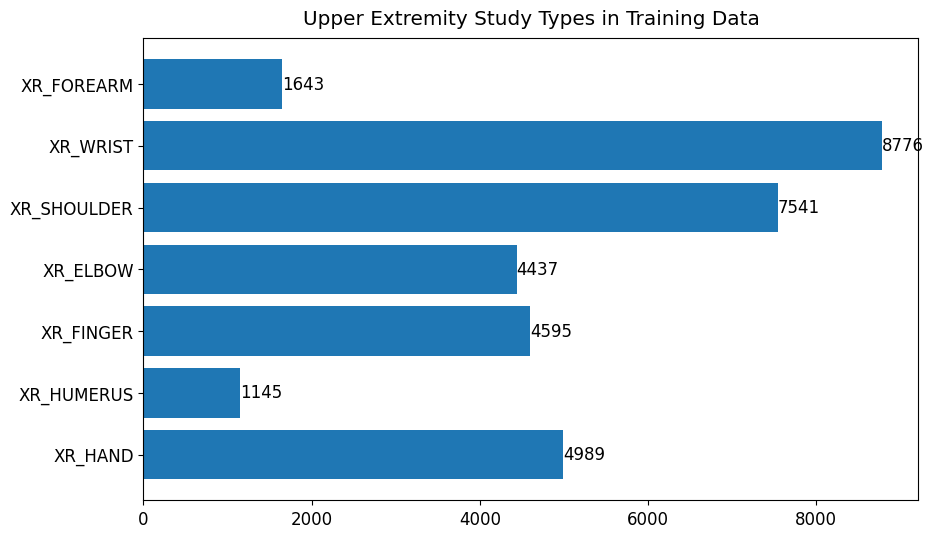

In [106]:
# Exploratory analysis
study_types = ['XR_HAND', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_SHOULDER', 'XR_WRIST', 'XR_FOREARM']

def print_type_values(df, title):
    study_counts = {}
    for study_type in study_types:
        study_counts[study_type] = (df.study_type == study_type).sum()
        
    fig, ax = plt.subplots(figsize = (10, 6))
    bars = ax.barh(list(study_counts.keys()), list(study_counts.values()))
    ax.bar_label(bars)
    plt.title(title, pad = 10)
    plt.show()

print_type_values(df_train, "Upper Extremity Study Types in Training Data")

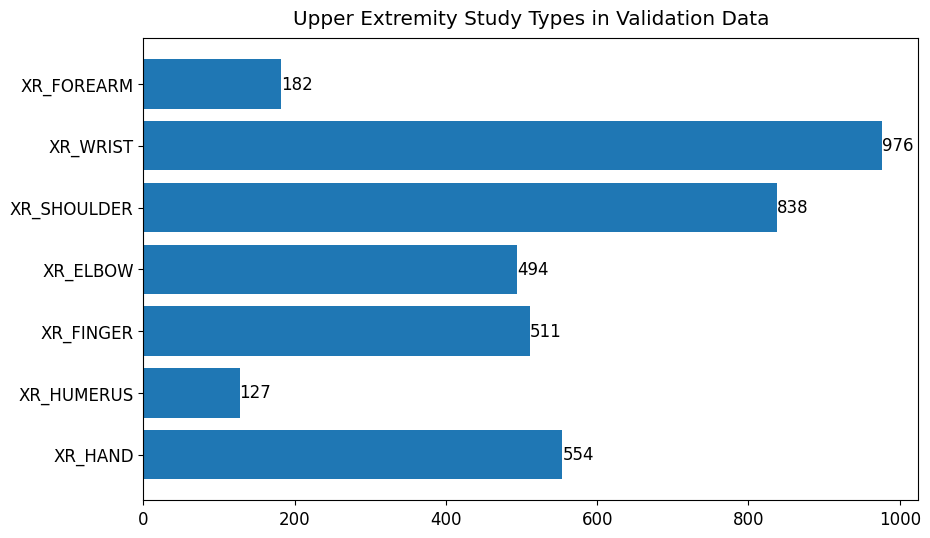

In [107]:
print_type_values(df_valid, "Upper Extremity Study Types in Validation Data")

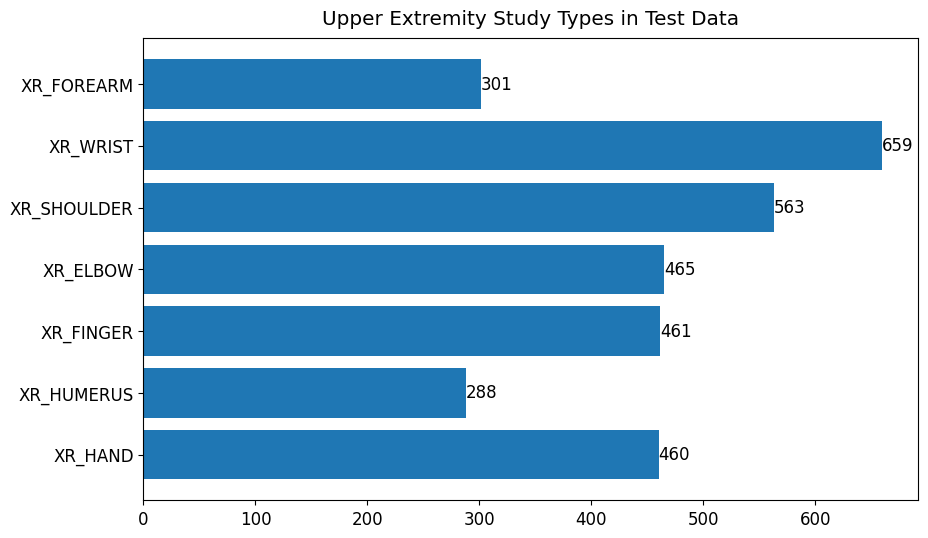

In [108]:
print_type_values(df_test, "Upper Extremity Study Types in Test Data")

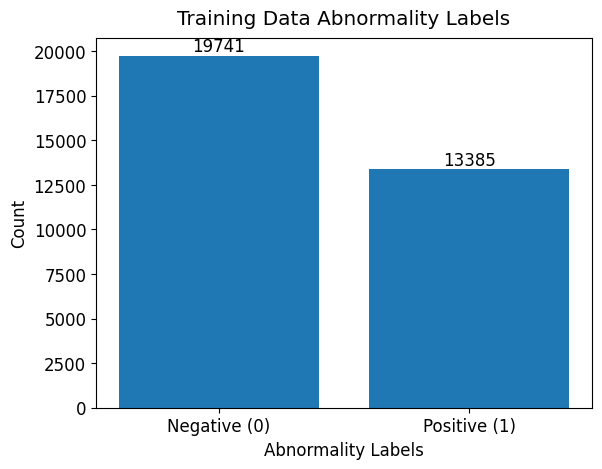

In [109]:
def print_labels(df, title):
    
    value_counts = df['label'].value_counts()
    
    bars = plt.bar(value_counts.index, value_counts.values)
    plt.xlabel('Abnormality Labels')
    plt.ylabel('Count')
    plt.title(title, pad = 10)
    plt.xticks(value_counts.index, ['Negative (0)', 'Positive (1)'])
    for bar, count in zip(bars, value_counts.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha = 'center', va = 'bottom')
    
    plt.show()

print_labels(df_train, "Training Data Abnormality Labels")

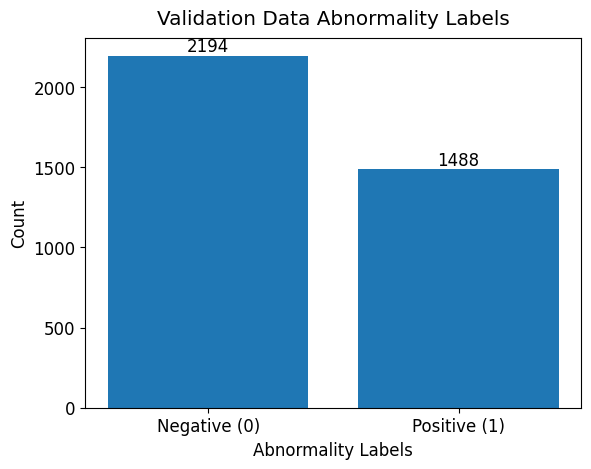

In [110]:
print_labels(df_valid, "Validation Data Abnormality Labels")

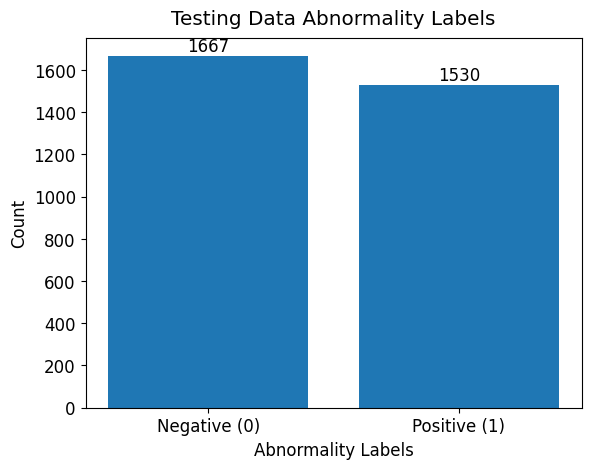

In [111]:
print_labels(df_test, "Testing Data Abnormality Labels")

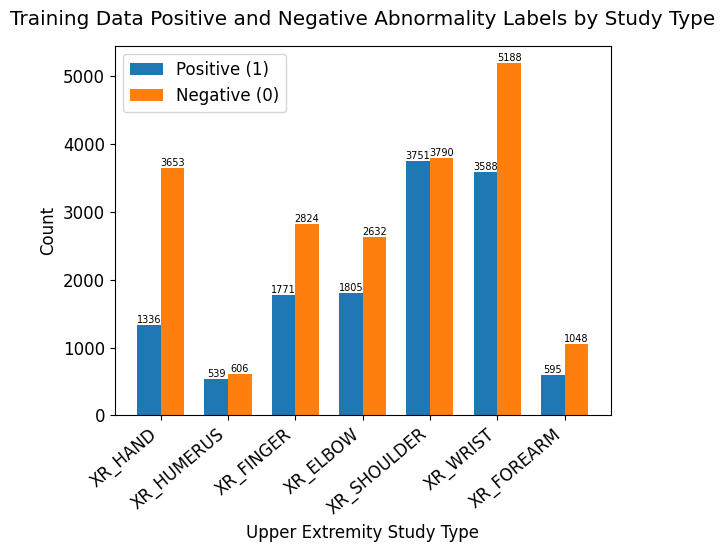

In [112]:
def print_labels_by_study_type(df, title):
    study_type_counts = []
    for study_type in study_types:
        positive_count = ((df.study_type == study_type) & (df.label == 1)).sum()
        negative_count = ((df.study_type == study_type) & (df.label == 0)).sum()
        study_type_counts.append((positive_count, negative_count))

    x = np.arange(len(study_types))
    width = 0.35
    
    fig, ax = plt.subplots()

    # Plot values
    positive_bars = ax.bar(x - width / 2, [count[0] for count in study_type_counts], width, label = 'Positive (1)')
    negative_bars = ax.bar(x + width / 2, [count[1] for count in study_type_counts], width, label = 'Negative (0)')
    ax.set_xlabel('Upper Extremity Study Type')
    ax.set_ylabel('Count')
    ax.set_title(title, pad = 15)
    ax.set_xticks(x)
    ax.set_xticklabels(study_types, rotation = 40, ha = 'right')
    ax.legend()
    
    for bar in positive_bars + negative_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha = 'center', va = 'bottom', fontsize = 7)
    
    plt.show()

print_labels_by_study_type(df_train, "Training Data Positive and Negative Abnormality Labels by Study Type")

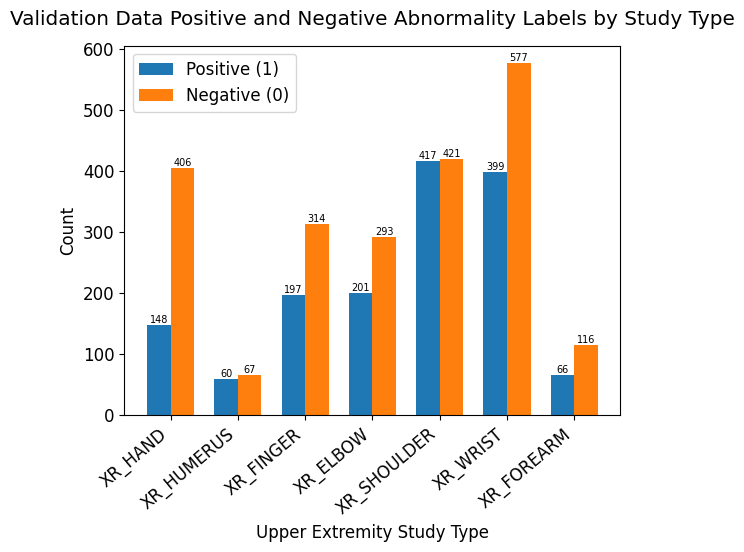

In [113]:
print_labels_by_study_type(df_valid, "Validation Data Positive and Negative Abnormality Labels by Study Type")

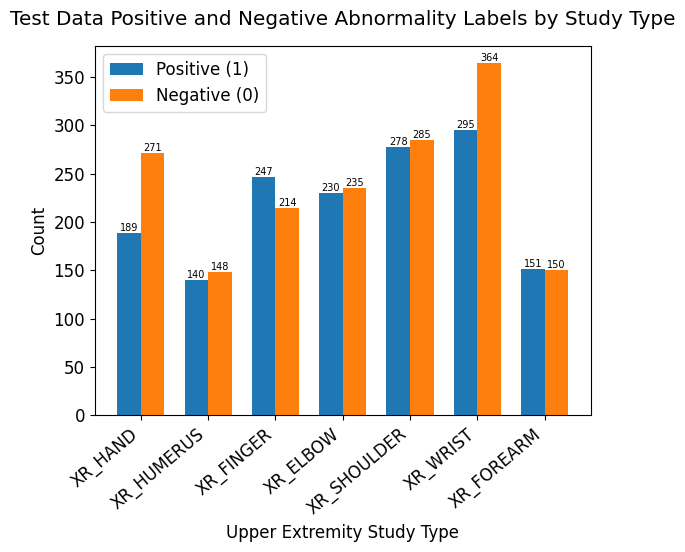

In [114]:
print_labels_by_study_type(df_test, "Test Data Positive and Negative Abnormality Labels by Study Type")

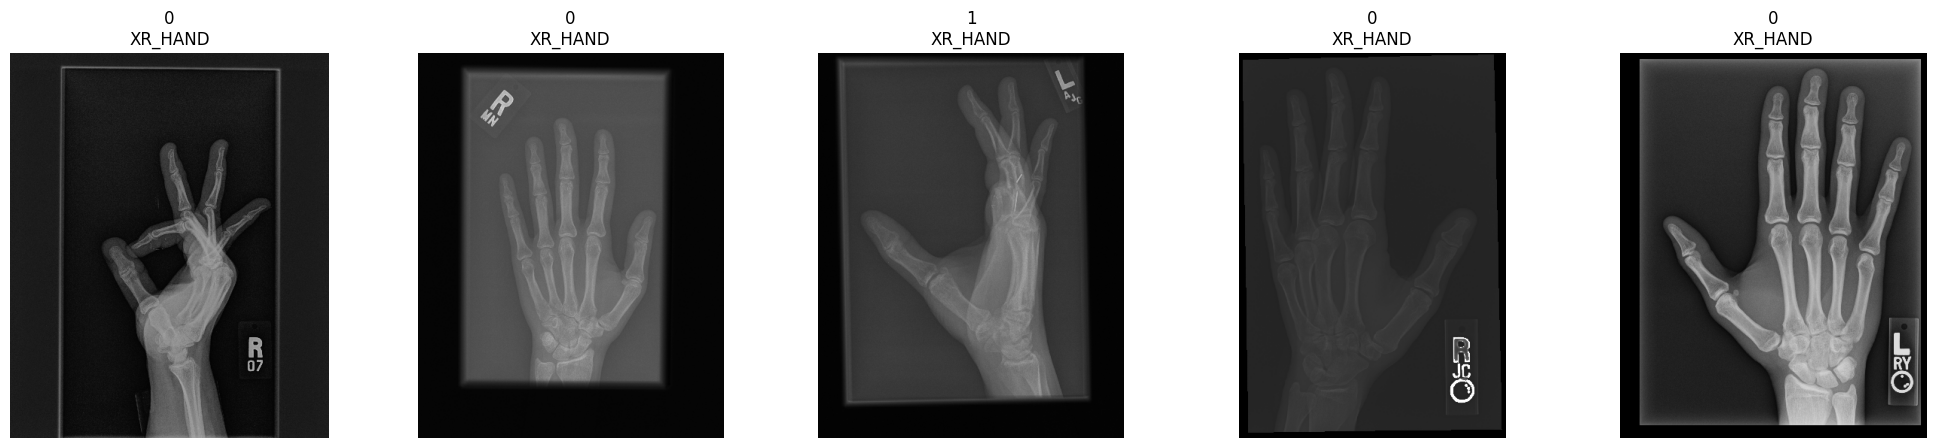

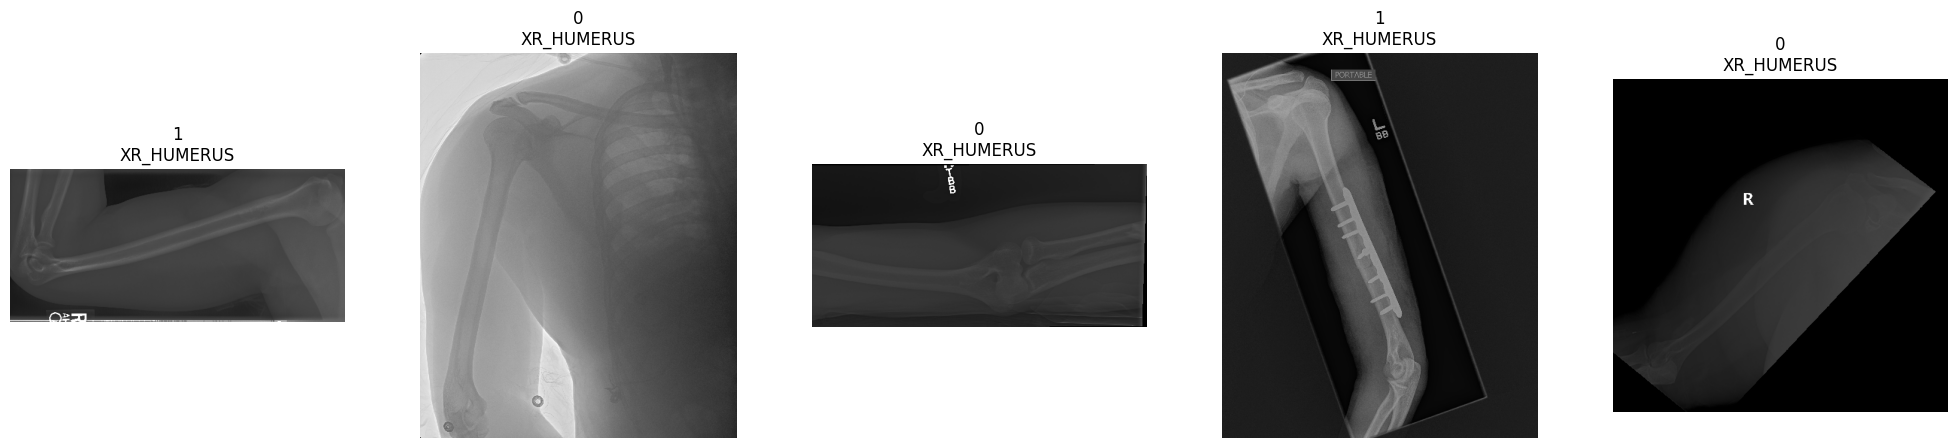

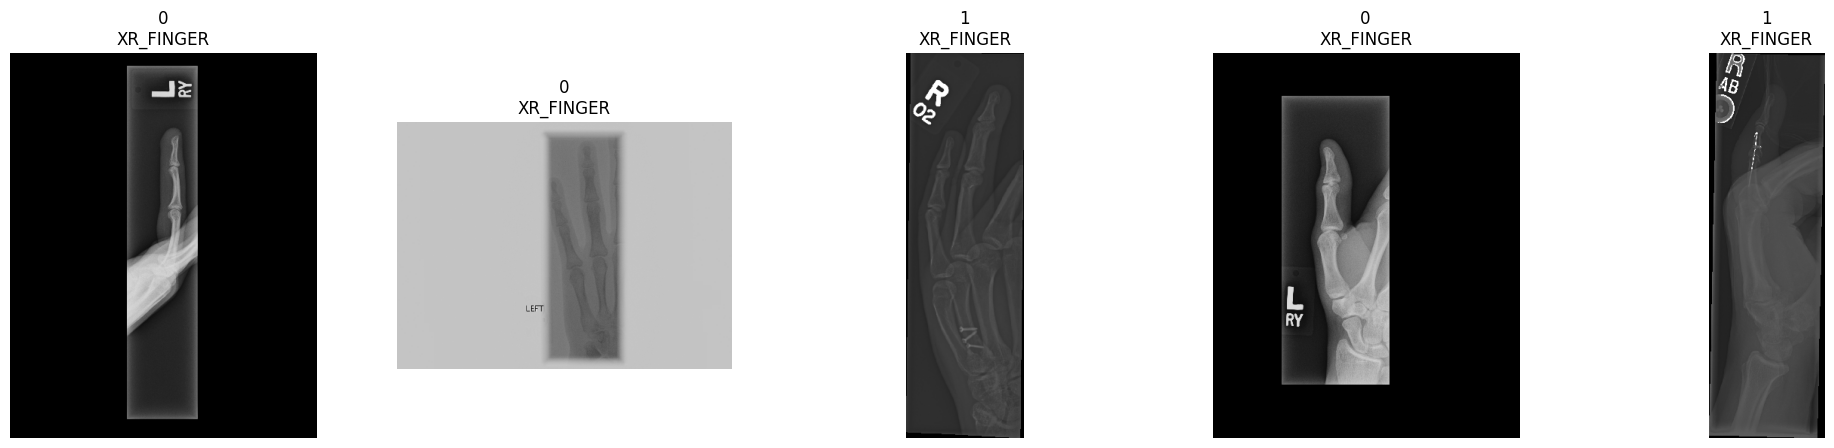

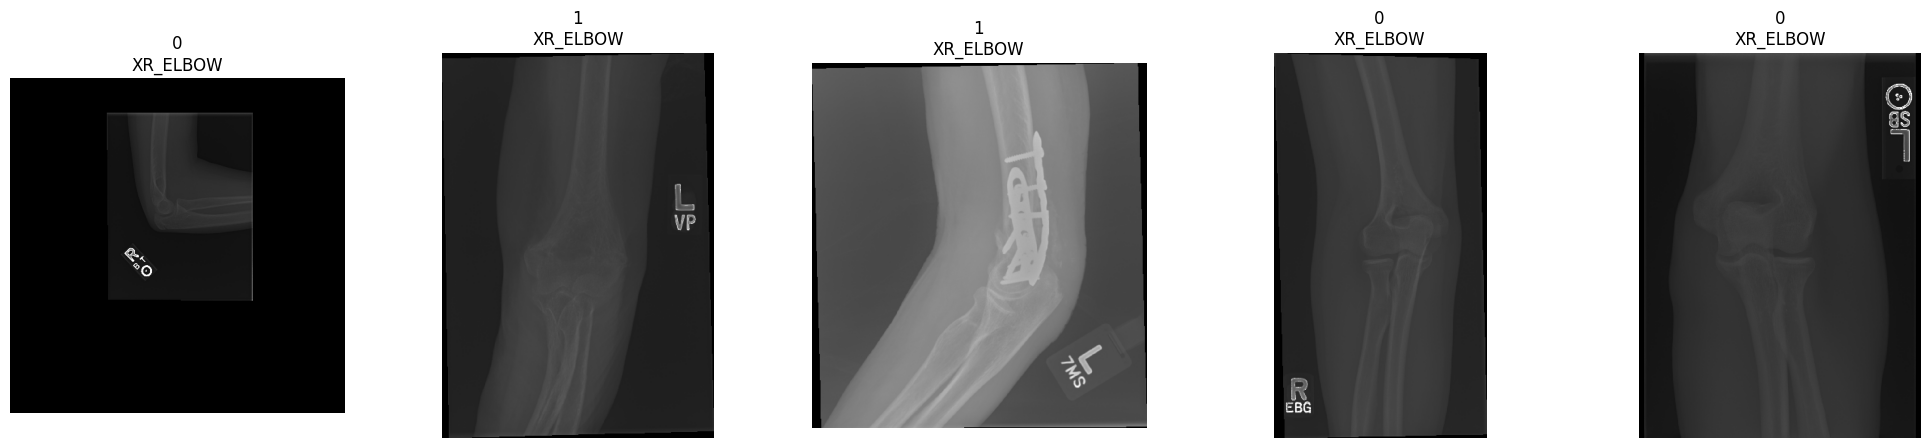

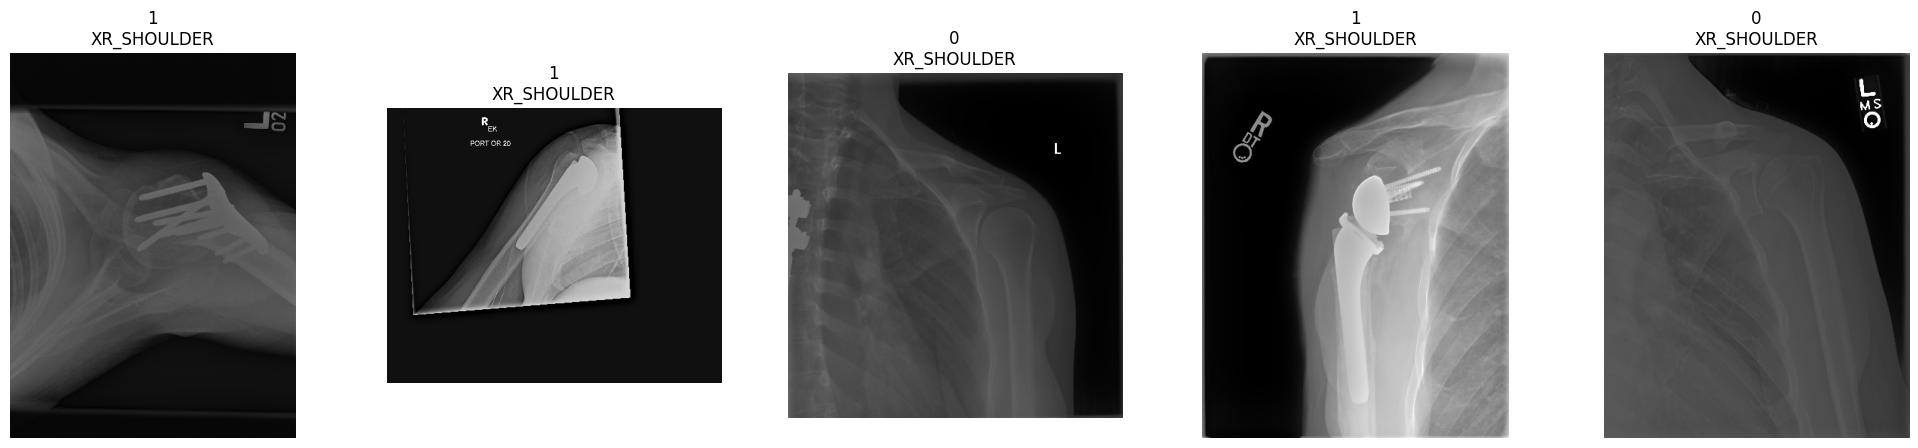

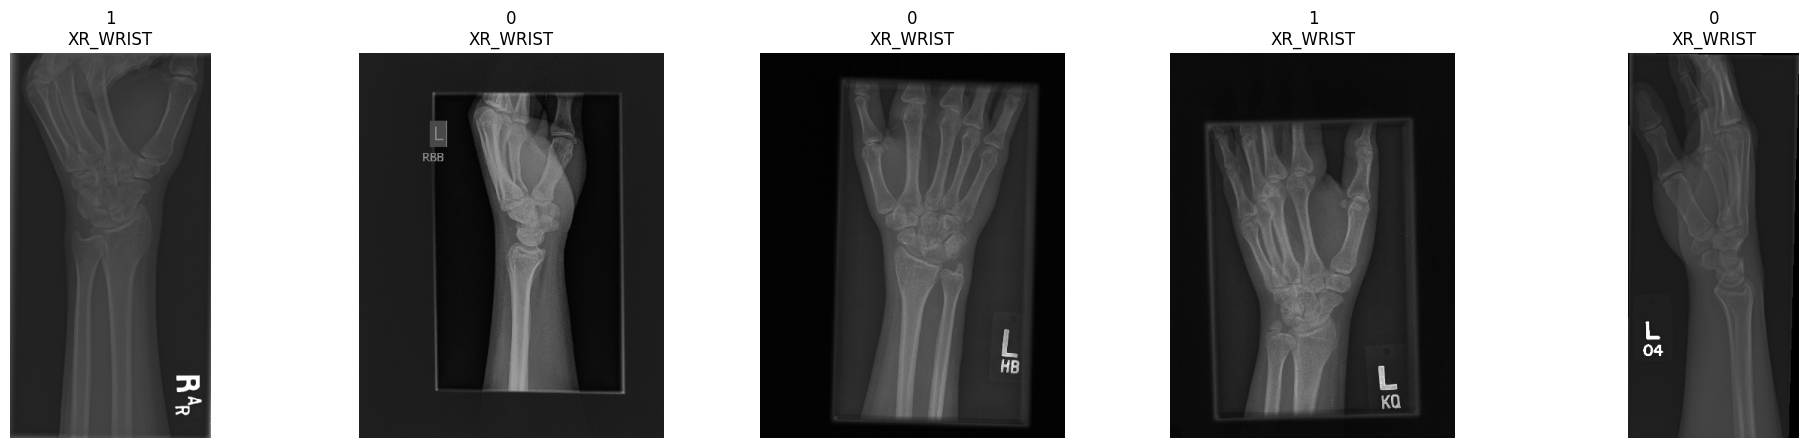

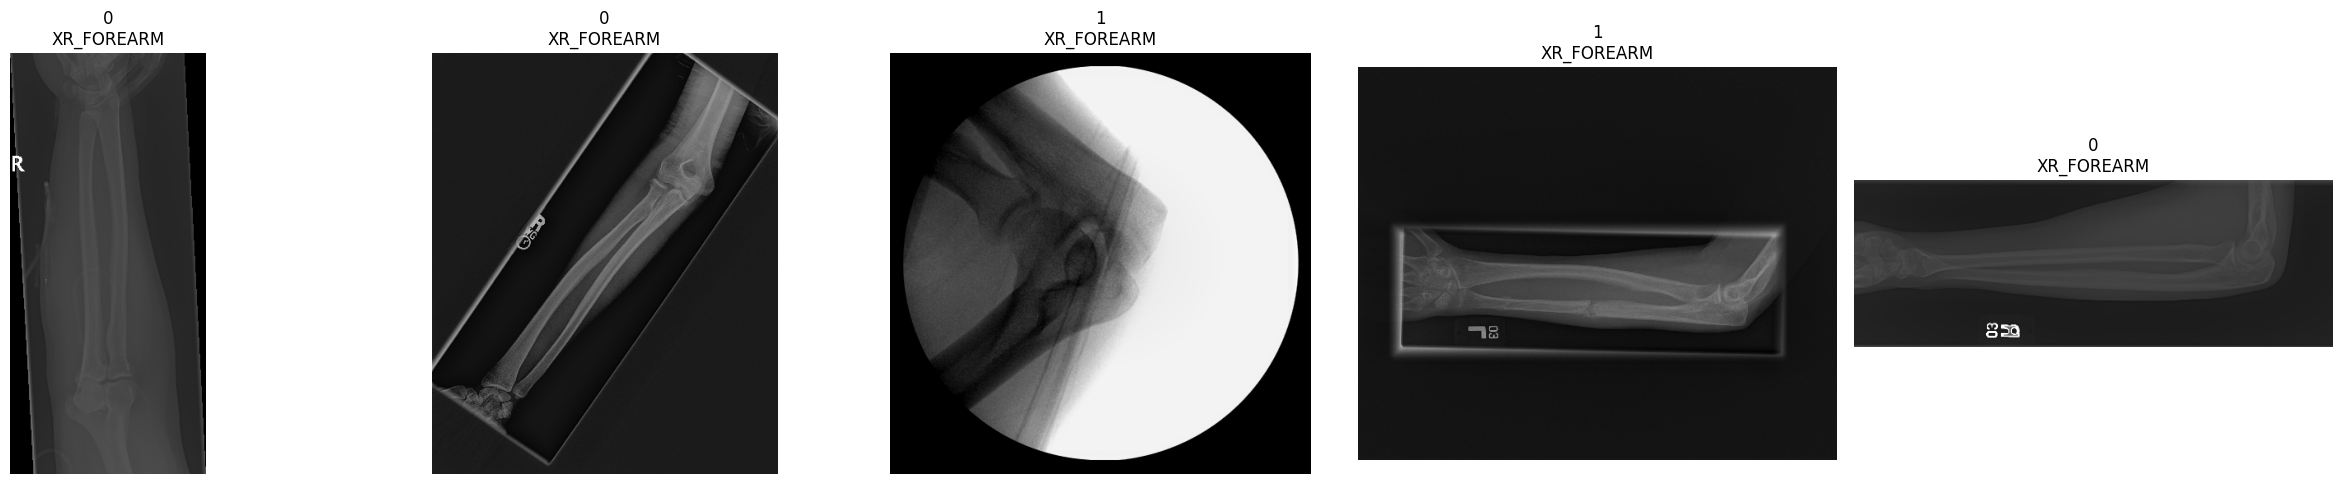

In [115]:
# Display sample of training images
for study_type in study_types:
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    imgs = df_train[df_train['study_type'] == study_type].sample(n = 5)
    for i, (image, label) in enumerate(zip(imgs['img_path'], imgs['label'])):
        image = load_img(image)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(str(label) + "\n" + study_type, fontsize=12)

plt.tight_layout()
plt.show()

In [116]:
# Convert labels to str
df_train['label'] = df_train['label'].replace({0: '0', 1: '1'})
df_valid['label'] = df_valid['label'].replace({0: '0', 1: '1'})
df_test['label'] = df_test['label'].replace({0: '0', 1: '1'})

In [117]:
# Data augmentation
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 33126 validated image filenames belonging to 2 classes.


In [118]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3682 validated image filenames belonging to 2 classes.


In [119]:
test_generator = datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3197 validated image filenames belonging to 2 classes.


# DenseNet
the following resource was utilized havily as a resource to implement transfer learning with DenseNet:

https://www.kaggle.com/code/cafelatte1/alien-and-predator-classification-beginner/notebook

In [120]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import keras
import random as rnd
import pathlib
import math
import re
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as sequential
from tensorflow.keras import applications as pretrained
from tensorflow.python.client import device_lib
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.utils import plot_model

# --- Processor option ---
# GPU setup
try:
    gpu = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu[0], True)
except:
    print("None of GPUs are detected")

In [121]:
cut_off = 0.5
epochs = 100

img_width = 224  # keep image sizes consistent with Michelle's code
img_height = 224
inputTensor = tf.keras.Input(shape=(img_width,img_height,3))


In [129]:


# Creating pretrained DenseNet model
def CreatingTopLayers(featureTensor):
    topLayers = None
    topLayers = sequential([
                    layers.GlobalAveragePooling2D(),
                    layers.Dropout(0.2),
                    layers.Dense(units=1, activation="sigmoid")
    ], name="Top_Layers")
    return(topLayers)

# Loading the base model
model_base = sequential([
     # layers.experimental.preprocessing.Rescaling(input_shape=(img_height, img_width, 3), scale=1.0/255, name="Rescailing"),
     # data_augmentation,
     pretrained.DenseNet201(input_shape=(img_width, img_height, 3), weights="imagenet", include_top=False)], name="Base_DenseNet201")

model_base.trainable = False
model_base.summary()

featureTensor = model_base(inputTensor)
topLayers = CreatingTopLayers(featureTensor)

modified_model = sequential([model_base, topLayers], name="DenseNet201")
modified_model.summary()

metricsVec = [
  metrics.BinaryAccuracy(threshold=cut_off),
  metrics.Precision(thresholds=cut_off),
  metrics.Recall(thresholds=cut_off),
  metrics.AUC()
]

modified_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*3),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=metricsVec)

def PlotingResult(his, result, name):
    acc = his.history['binary_accuracy']
    val_acc = his.history['val_binary_accuracy']
    loss = his.history['loss']
    val_loss = his.history['val_loss']

    plt.figure(figsize=(16, 9))
    plt.rc('font', size=12)

    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    title = 'Training and Validation Accuracy (' + his.model.name + ')'
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper left')
    title = 'Training and Validation Loss (' + his.model.name + ')'
    plt.title(title)
    plt.show()

    bestIdx = 0
    val_accuracy = 0
    val_precision = 0
    val_recall = 0
    val_auc = 0
    val_f1 = 0

    for i,j in his.history.items():
        if "val_loss" in i:
            bestIdx = np.argmin(j)
            val_loss = j[-1]

    for i,j in his.history.items():
        if "val_binary_accuracy" in i:
            val_accuracy = j[-1]
        elif "val_precision" in i:
            val_precision = j[-1]
        elif "val_recall" in i:
            val_recall = j[-1]
        elif "val_auc" in i:
            val_auc = j[-1]
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

    return [val_accuracy, val_f1, val_auc, val_loss, len(his.epoch)]

def SquareRootScheduler(epochCount, lr):
    return lr * pow(epochCount+1.0, -0.5)

cb_lrscheduler = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler)
cb_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=math.floor(epochs*0.01))

Model: "Base_DenseNet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

Model: "DenseNet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Base_DenseNet201 (Sequential)   │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Top_Layers (Sequential)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

Text(0, 0.5, 'Learning rate')

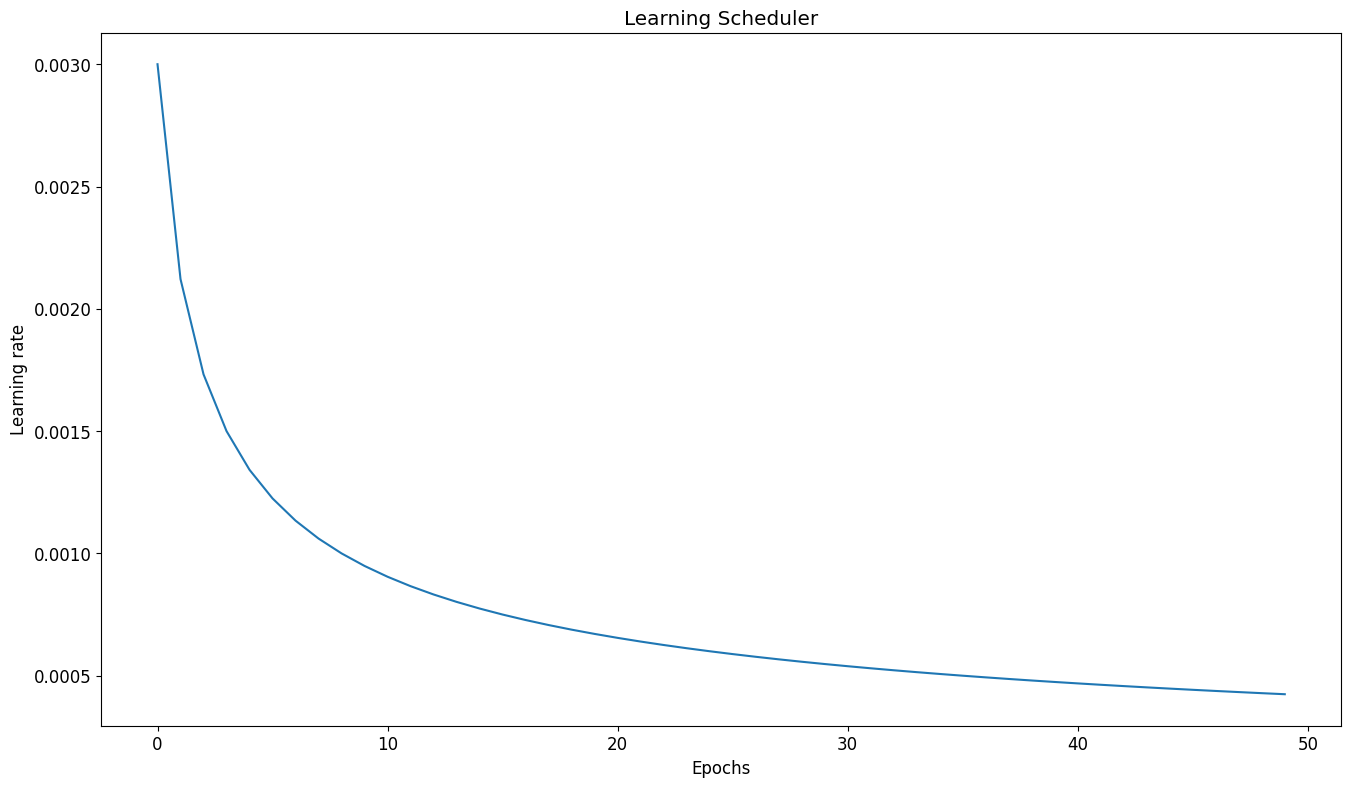

In [130]:
tmpEpochs = list(range(50))
tmpLr = list(map(lambda x: SquareRootScheduler(x, tf.keras.optimizers.Adam().get_config()["learning_rate"]*3), tmpEpochs))

plt.figure(figsize=(16, 9))
plt.rc('font', size=12)
plt.plot(tmpEpochs, tmpLr, label='Training Accuracy')
plt.title("Learning Scheduler")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")

In [ ]:
# print(modelVec[3])
tf.random.set_seed(2000)
# model_DenseNet201 = None
# model_DenseNet201 = CreatingModels(modelVec[3])
model_DenseNet201 = modified_model
history_DenseNet201 = None
history_DenseNet201 = model_DenseNet201.fit(
  train_generator,
  batch_size=None,
  validation_data=valid_generator,
  validation_batch_size=None,
  epochs=1,  # temporarily 1 for now
  callbacks=[cb_lrscheduler, cb_earlystopping],
  verbose=1
)

result = pd.DataFrame({'Accuracy' : None,
       'F1' : None,
       'AUC' : None,
       'Loss' : None,
       'Epoch' : None                
})
result.index = 'DenseNet201'

result = PlotingResult(history_DenseNet201, result, 'DenseNet201')
result

173/518 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - auc_3: 0.7805 - binary_accuracy: 0.7308 - loss: 0.5465 - precision_3: 0.7058 - recall_3: 0.5718